In [88]:
import numpy as np
import pandas as pd
import glob
import re
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.speedups; shapely.speedups.enable()
import geopandas as gp
from geopandas import GeoDataFrame, sjoin
import matplotlib.pyplot as plt
import mplleaflet
from IPython.display import IFrame
crs = {'init': 'epsg:4326'}
crs_afwijkend = {'init': 'epsg:28992'}
import warnings; warnings.filterwarnings(action='once')

In [2]:
# # Importeer BAG-data
# real_estate_data = pd.read_csv('data/real_estate_data.csv', dtype=str)
# bag = pd.read_csv('data/BAG_data_Amsterdam.csv', dtype=str)

# # Importeer groene daken
# df = pd.read_csv('data/daken/GROENE_DAKEN.csv', sep=';')
# df['geometry'] = df.WKT_LNG_LAT.str.replace(',', ' ')
# df = GeoDataFrame(df, crs=crs, geometry=df.geometry.apply(wkt.loads)).\
#     drop(columns=['OBJECTNUMMER', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'Unnamed: 14'])

In [3]:
# Importeer gemeentelijke data
bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['WKT_LNG_LAT'], dtype=str) 
                   for file in glob.glob('data\BOMEN*.csv')], axis=0, ignore_index=True)
grond = pd.read_csv('data/GRONDGEBRUIK_2017.csv', sep=';', usecols=['AMScode_Oms', 'WKT_LNG_LAT'])

bomen['geometry'] = bomen.WKT_LNG_LAT.str.replace(',', ' ')
grond.rename(columns={'WKT_LNG_LAT':'geometry'}, inplace=True)

bomen = GeoDataFrame(bomen, crs=crs, geometry=bomen.geometry.apply(wkt.loads)).drop(columns='WKT_LNG_LAT')
grond = GeoDataFrame(grond, crs=crs, geometry=grond.geometry.apply(wkt.loads))

merged = sjoin(grond, bomen).groupby('AMScode_Oms').count()

In [4]:
# Om een koppeling te maken tussen postcodes, stadsdelen, en coordinaten: 
pc4 = pd.read_csv('data/020/PC4_BUURTEN.csv', dtype=str, sep=';').\
    drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 7'])
pc6 = pd.read_csv('data/020/PC6_VLAKKEN_BAG.csv', dtype=str, sep=';').\
    drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 7'])
sd = pd.read_csv('data/020/GEBIED_STADSDELEN.csv', dtype=str, sep=';').\
    drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 8'])
buurten = pd.read_csv('data/020/GEBIED_BUURTEN.csv', dtype=str, sep=';').\
    drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 10']).\
    rename(index=str, columns={'Buurt_code': 'Buurtcode'})

for df in [pc4, pc6, sd, buurten]:
    df.rename(columns={'WKT_LNG_LAT':'geometry'}, inplace=True)

pc4 = GeoDataFrame(pc4, crs=crs, geometry=pc4.geometry.apply(wkt.loads))
pc6 = GeoDataFrame(pc6, crs=crs, geometry=pc6.geometry.apply(wkt.loads))
sd = GeoDataFrame(sd, crs=crs, geometry=sd.geometry.apply(wkt.loads))
buurten = GeoDataFrame(buurten, crs=crs, geometry=buurten.geometry.apply(wkt.loads))

# Maak een dataframe met gematchte postcodes en stadsdelen, en bijbehorende polygonen
polygons = pc6.merge(buurten[['Buurtcode', 'Stadsdeel_code']], on=['Buurtcode']).\
    merge(sd[['Stadsdeel', 'Stadsdeel_code', 'geometry']], on=['Stadsdeel_code'], suffixes=('_PC', '_SD')).\
    drop(columns=[
#     'Buurtcode', 
    'Stadsdeel_code'])

# polygons.to_csv('polygons.csv', index=False, encoding='utf8')

In [160]:
# Parkeervakken
cols = ['WKT', 'buurtcode', 'straatnaam', 'aantal']
dtypes = None  # zip(cols, [str, str, str, int64])
pv = pd.read_csv('data/parkeervakken.csv', 
                 usecols=cols, 
                 dtype=dtypes).\
    rename(index=str, columns={'buurtcode': 'Buurtcode', 'WKT': 'geometry'})

pv = pv.merge(buurten[['Buurtcode', 'Stadsdeel_code']], on=['Buurtcode']).\
    merge(sd[['Stadsdeel', 'Stadsdeel_code']], on=['Stadsdeel_code']).\
    drop(columns=[
#     'Buurtcode', 
    'Stadsdeel_code'])

# GeoDataFrame maken van DataFrame, werken met copy!
gdf_pv = GeoDataFrame(pv.copy(), crs=crs_afwijkend, geometry=pv.geometry.apply(wkt.loads))
gdf_pv['geometry'] = gdf_pv.geometry.to_crs(epsg=4326)  # naar leesbare coordinaten
gdf_pv.crs = {'init': 'epsg:4326'}  # voor de zekerheid

# Controleren of er minimaal twee parkeervakken naast elkaar zitten
aantal_vakken = GeoDataFrame(pv.copy(), crs=crs_afwijkend, geometry=pv.geometry.apply(wkt.loads))
aantal_vakken['geometry'] = aantal_vakken.geometry.to_crs({'proj':'cea'})
aantal_vakken.crs = {'proj': 'cea'}  # om afstanden en oppervlakte te kunnen berekenen

# Update bron-GeoDataFrame met afstanden tussen en oppervlakte van parkeervakken voor later gebruik
gdf_pv['Oppervlakte'] = aantal_vakken.geometry.area  # uitrekenen van oppervlakte
gdf_pv['afstand'] = [0.] + [aantal_vakken.geometry[i].centroid.distance(aantal_vakken.geometry[i-1].centroid) for i in range(1, len(aantal_vakken))]
gdf_pv = gdf_pv[gdf_pv.afstand < 5]  # Let op: filter!
del aantal_vakken

# Grondgebruik toevoegen
grondgebruik = sjoin(gdf_pv, grond).drop(columns=['index_right'])
grondgebruik = grondgebruik.groupby(grondgebruik.index).agg(list)
codes = grondgebruik.AMScode_Oms.copy()
grondgebruik = grondgebruik.drop(columns=['AMScode_Oms']).applymap(lambda x: x[0])
grondgebruik['AMScode_Oms'] = codes.copy()

gdf_pv = GeoDataFrame(grondgebruik)
# # dit is in principe onnodig: 
# gdf_pv = GeoDataFrame(grondgebruik, crs=crs_afwijkend)
# gdf_pv['geometry'] = gdf_pv.geometry.to_crs(epsg=4326)
# gdf_pv.crs = {'init': 'epsg:4326'}
del grondgebruik, codes

# to_keep = ['Wegverkeersterrein', 'Wegverkeersterrein rijkswegen', 'Wegverkeersterrein provinciale wegen', 'Woonterrein', 'Detailhandel, winkelcentra en horeca', 'Overheid (kantoor/dienstverlening/openbare voorzieningen)', 'Overheid (nutsbedrijven/defensieterrein)', 'Sociaal-culturele voorzieningen (incl. onderwijs, gezondheidszorg)', 'Bedrijventerrein (industrie, tentoonstellingsterrein, garagebedrijven)', 'Bedrijventerrein (overwegend kantoren/kantoorachtig)', 'Bouwterrein woonbestemming', 'Bouwterrein niet-woonbestemming', 'Semi verhard overig terrein', 'Parkeerterrein ArenA', 'Dagrecreatief terrein', 'Verblijfsrecreatief terrein', 'Open droog-natuurlijk terrein', 'Open nat-natuurlijk terrein', 'Open nat-natuurlijk terrein met schotse hooglanders']
# to_drop = ['Spoorterrein', 'Metro, vrije trambanen', 'Bedrijfsspoor', 'Vliegveld (niet het gras)', 'Stortplaats', 'Wrakkenopslagplaats', 'Begraafplaats', 'Tijdelijke opslag van grond', 'Park en plantsoen', 'Sportterrein', 'Golfterrein', 'Open nat-natuurlijk terrein waterpartijen', 'IJsselmeer/Markermeer', 'Recreatief binnenwater', 'Recreatief binnenwater grote plas', 'Water in park/plantsoen', 'Water in golfterrein', 'Overig water breder dan 6 m.', 'Overig water `t IJ', 'Overig water grote plassen''Artis', 'Terrein voor glastuinbouw', 'Overig agrarisch terrein', 'Bos', 'Volkstuin']
# gdf_pv = gdf_pv[~gdf_pv.grondgebruik.isin(to_drop)]

# Controleren of er minimaal vier parkeervakken in de straat zitten
vakken_per_straat = gdf_pv.groupby(['straatnaam']).sum().reset_index()
gdf_pv = gdf_pv[gdf_pv.straatnaam.isin(vakken_per_straat[vakken_per_straat.aantal >= 4].straatnaam)]  # Let op: filter!
del vakken_per_straat

# Maak GeoDataFrame met aantal parkeervakken per buurt voor alle stadsdelen
vakken_per_buurt = GeoDataFrame(gdf_pv.copy().groupby(['Buurtcode']).sum().reset_index().\
    merge(buurten[['geometry', 'Buurtcode']], on=['Buurtcode']).drop(columns=['afstand']))

# Maak GeoDataFrame met aantal parkeervakken per buurt in stadsdeel Centrum
centrum = GeoDataFrame(gdf_pv[gdf_pv.Stadsdeel == 'Centrum'].copy().groupby(['Buurtcode']).sum().reset_index().\
    merge(buurten[['geometry', 'Buurtcode']], on=['Buurtcode']).drop(columns=['afstand']))

# Maak GeoDataFrame met geometrie van parkeervakken voor alle stadsdelen
alle_vakken = GeoDataFrame(gdf_pv.geometry.copy().reset_index().drop(columns=['index']))

# Maak GeoDataFrame met geometrie van parkeervakken in stadsdeel Centrum
vakken = GeoDataFrame(gdf_pv[gdf_pv.Stadsdeel == 'Centrum'].geometry.copy().reset_index().drop(columns=['index']))

C:\Users\PSaalbrink\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


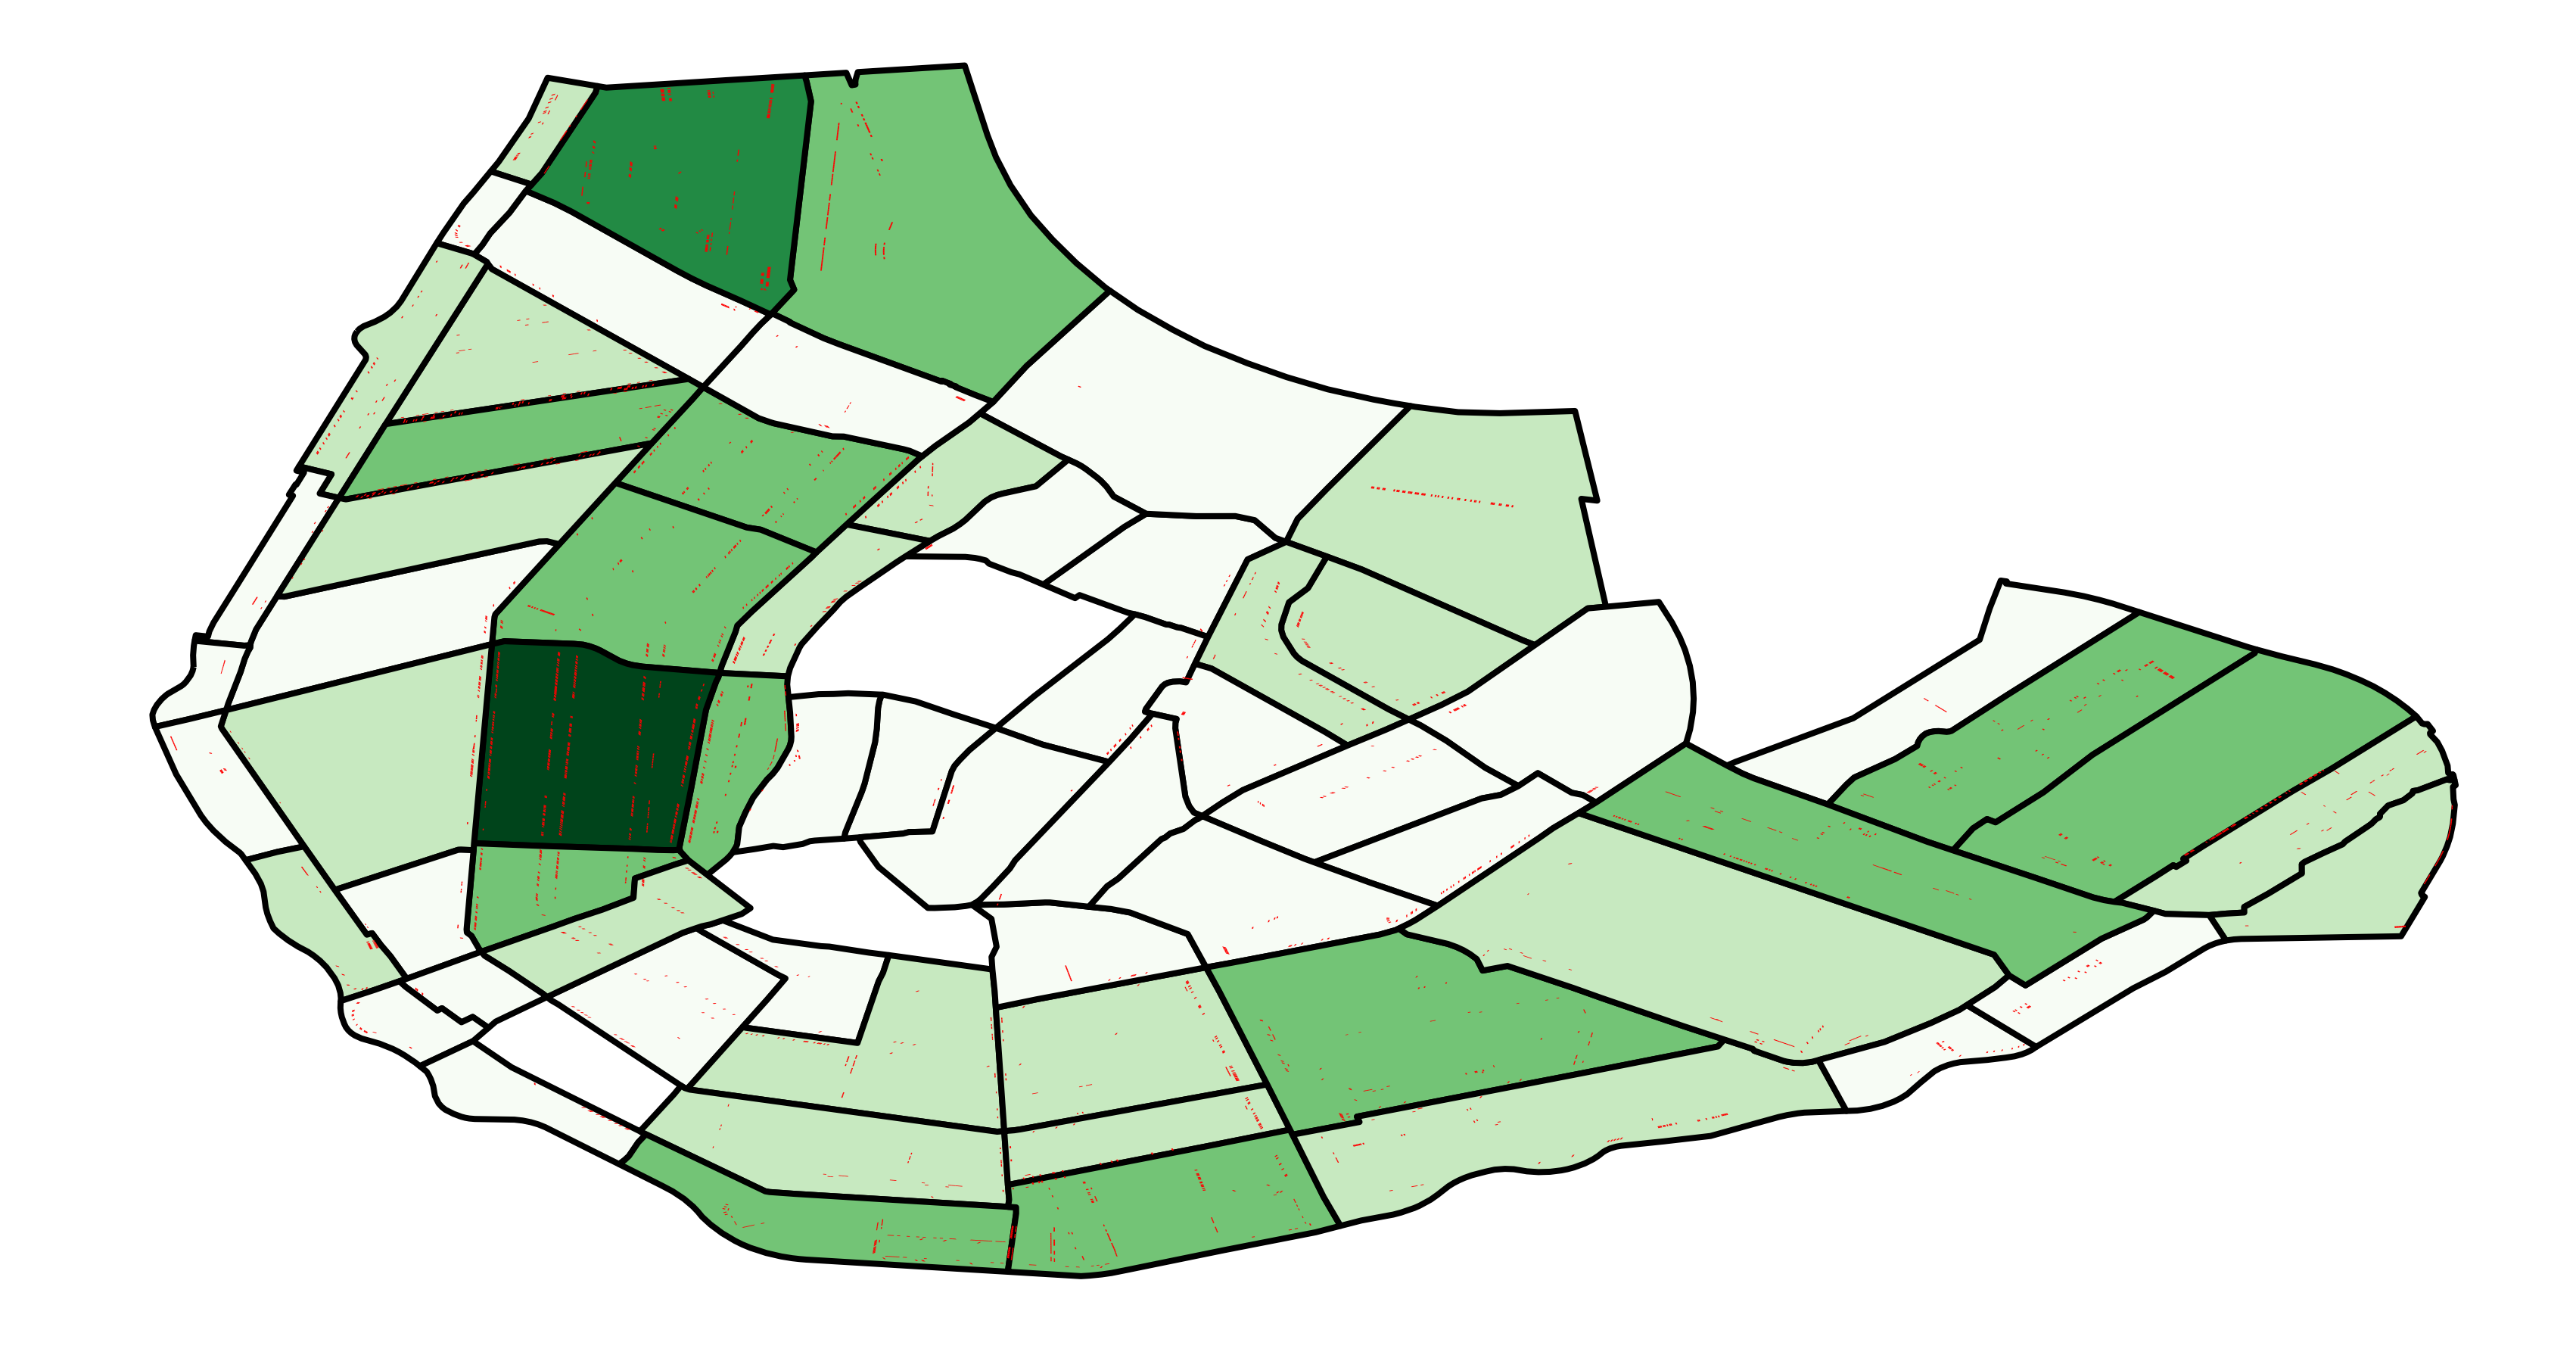

In [152]:
# Maak een plot van Amsterdam-Centrum, met groene kleuring naar aantal parkeervakken, en in rood de vakken zelf
# vmin, vmax = 10, 20
fig, ax = plt.subplots(1, figsize=(60, 60))
plt.axis('off')
centrum.plot(ax=ax, column='aantal', cmap='Greens', linewidth=8, edgecolor='0', scheme='Fisher_Jenks')
vakken.plot(ax=ax, color='red');

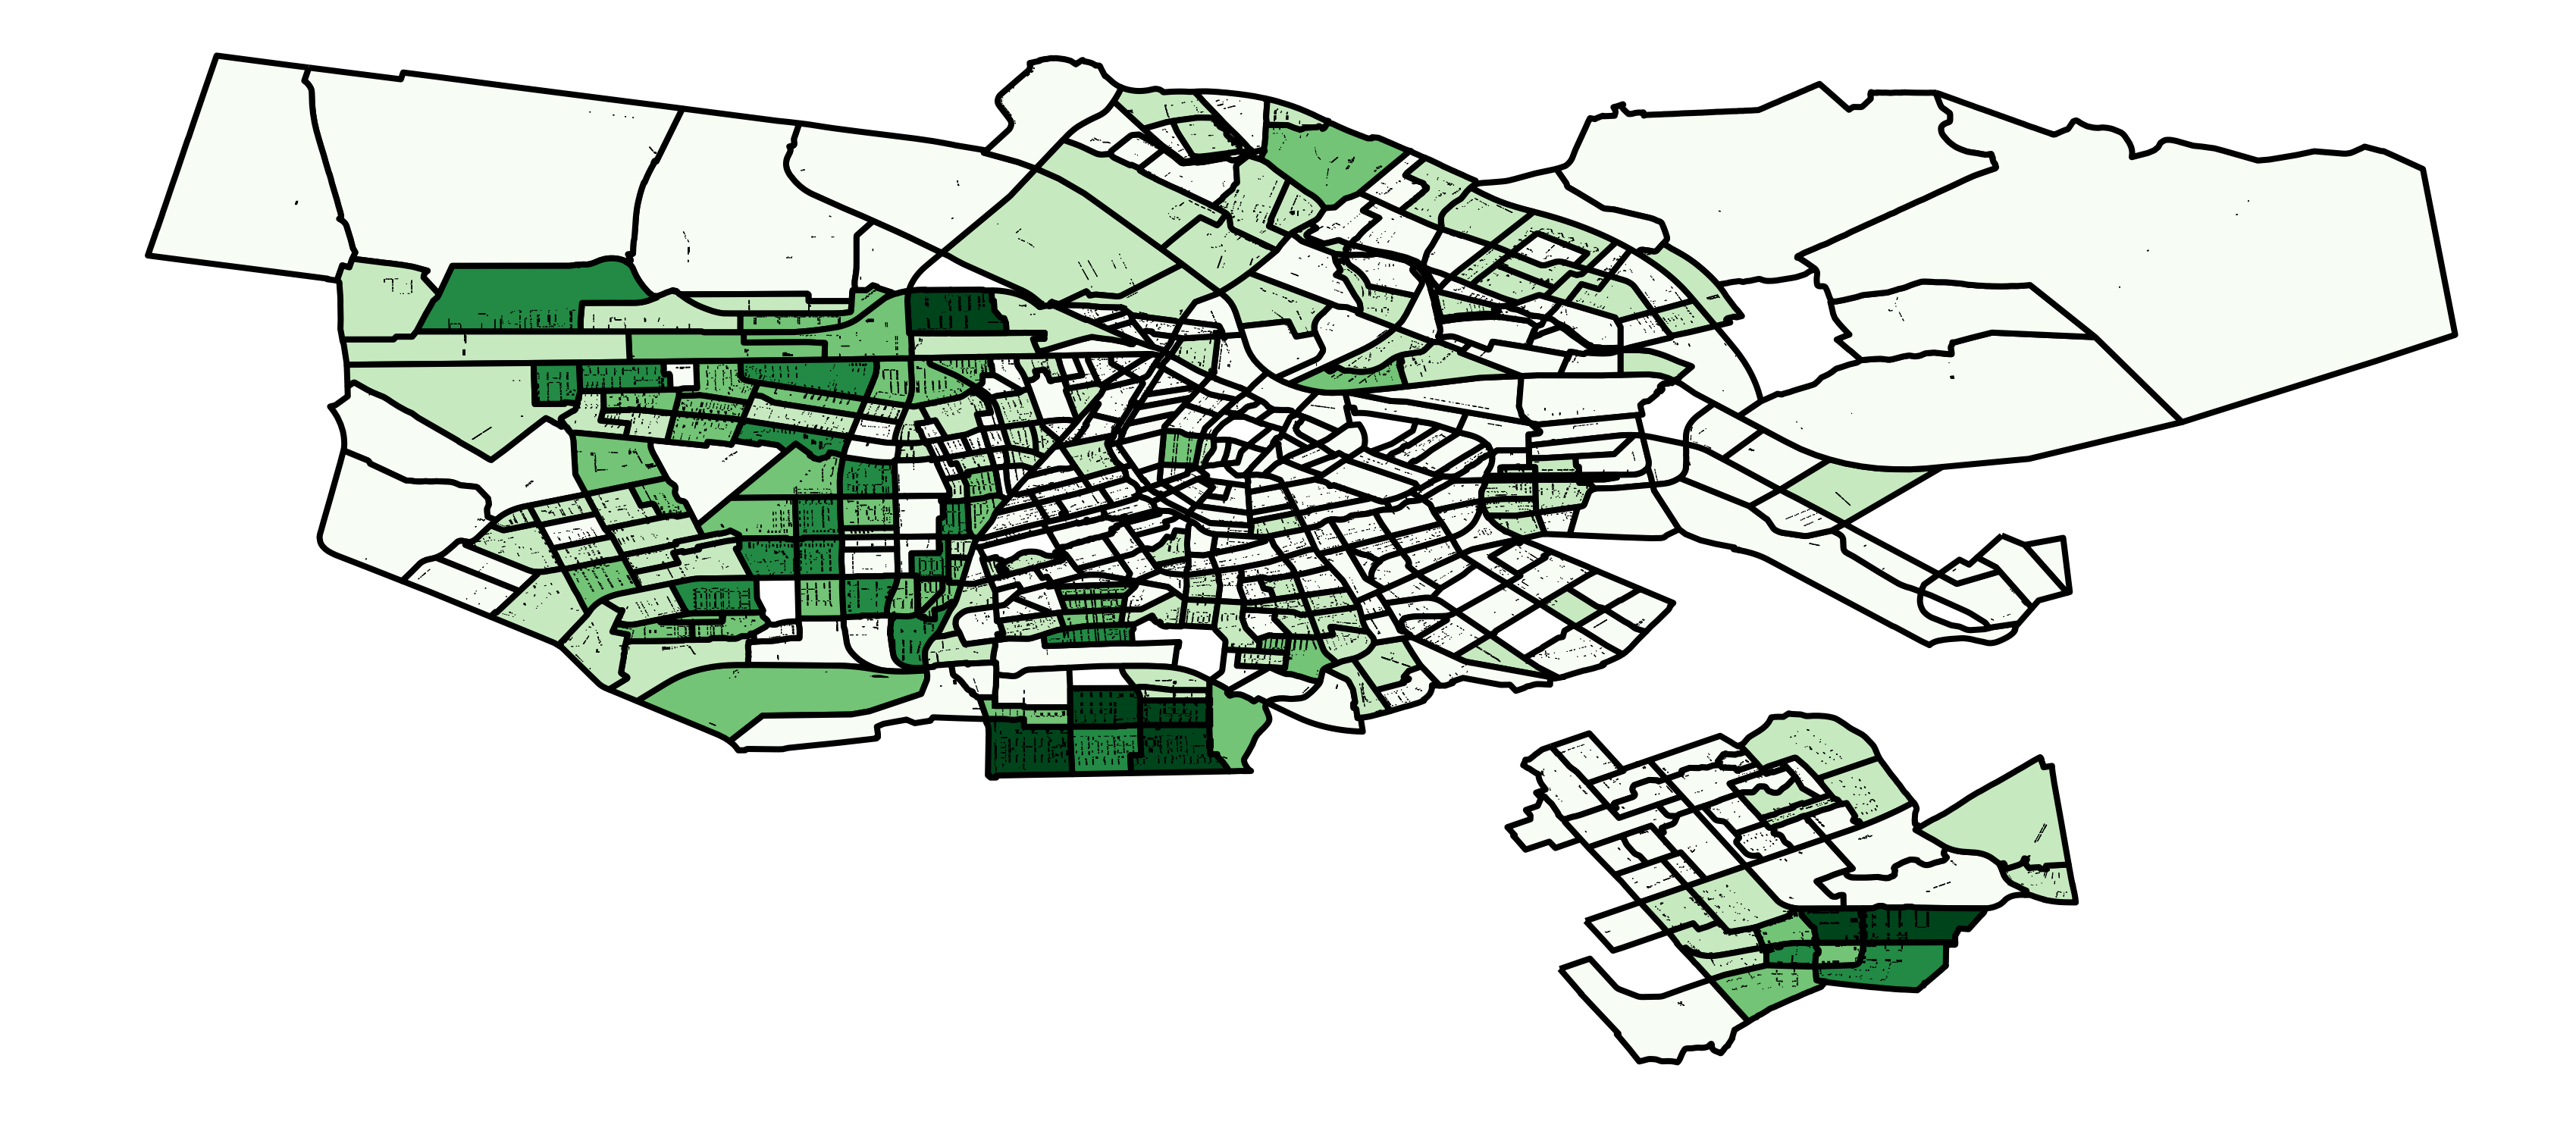

In [161]:
fig, ax = plt.subplots(1, figsize=(60, 60))
plt.axis('off')
vakken_per_buurt.plot(ax=ax, column='aantal', cmap='Greens', linewidth=8, edgecolor='black', scheme='Fisher_Jenks')
alle_vakken.plot(ax=ax, edgecolor='black');

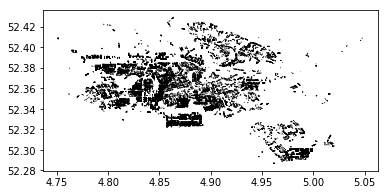

In [159]:
# Maak een plot van Centrum over de kaart van Amsterdam, met groene kleuring naar aantal parkeervakken
ax = centrum.plot(column='aantal', cmap='Accent', edgecolor='black')
# plt.axis('off');
# mplleaflet.display(fig=ax.figure, tiles='cartodb_positron')